### <font style="color:blue">Project 2: Kaggle Competition - Classification</font>

#### Maximum Points: 100

<div>
    <table>
        <tr><td><h3>Sr. no.</h3></td> <td><h3>Section</h3></td> <td><h3>Points</h3></td> </tr>
        <tr><td><h3>1</h3></td> <td><h3>Data Loader</h3></td> <td><h3>10</h3></td> </tr>
        <tr><td><h3>2</h3></td> <td><h3>Configuration</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>3</h3></td> <td><h3>Evaluation Metric</h3></td> <td><h3>10</h3></td> </tr>
        <tr><td><h3>4</h3></td> <td><h3>Train and Validation</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>5</h3></td> <td><h3>Model</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>6</h3></td> <td><h3>Utils</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>7</h3></td> <td><h3>Experiment</h3></td><td><h3>5</h3></td> </tr>
        <tr><td><h3>8</h3></td> <td><h3>TensorBoard Dev Scalars Log Link</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>9</h3></td> <td><h3>Kaggle Profile Link</h3></td> <td><h3>50</h3></td> </tr>
    </table>
</div>


## <font style="color:green"> Imports

In [38]:
import os
import time
from dataclasses import dataclass
from typing import List, Union, Tuple

import albumentations as A
from albumentations.pytorch import ToTensorV2

import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import torch as torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.utils as utils
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from torch.utils.tensorboard import SummaryWriter

from torchvision import datasets, transforms
import torchvision.models as models
from torchvision.models import resnet50, ResNet50_Weights

from torchmetrics import MeanMetric
from torchmetrics.classification import MulticlassAccuracy

from tqdm import tqdm  # For progress bar

# Text formatting
bold = "\033[1m"
end = "\033[0m"

plt.style.use('ggplot')
block_plot=False

%matplotlib inline

In [39]:
#!pip install efficientnet_pytorch 
#from efficientnet_pytorch import EfficientNet

## <font style="color:green">1. Data Loader [10 Points]</font>

In this section, you have to write a class or methods, which will be used to get training and validation data loader.

You need to write a custom dataset class to load data.

**Note; There is   no separate validation data. , You will thus have to create your own validation set, by dividing the train data into train and validation data. Usually, we do 80:20 ratio for train and validation, respectively.**


For example:

```python
class KenyanFood13Dataset(Dataset):
    """
    
    """
    
    def __init__(self, *args):
    ....
    ...
    
    def __getitem__(self, idx):
    ...
    ...
    

```


```python
def get_data(args1, *args):
    ....
    ....
    return train_loader, test_loader
```

### <font style="color:purple">Prepare Data

Splits data into 80/20 Train and Valid datasets and saves them.

In [40]:
class KenyanFood13Dataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        """
        Args:
            csv_file (str): Path to the CSV file with image IDs and labels.
            img_dir (str): Directory where images are stored.
            transform (callable, optional): Transformations to apply to the images.
        """
        self.data = pd.read_csv(csv_file)  # Load CSV file
        self.img_dir = img_dir
        self.transform = transform

        # Ensure consistent class-to-index mapping
        self.class_to_idx = {label: idx for idx, label in enumerate(sorted(self.data['class'].unique()))}
        self.data['class_idx'] = self.data['class'].map(self.class_to_idx)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = str(self.data.iloc[idx, 0])  # Read filename from CSV
        img_path = os.path.join(self.img_dir, img_name)
    
        # Check if the file exists with different extensions
        if not os.path.exists(img_path):
            possible_extensions = [".jpg", ".jpeg", ".png"]
            for ext in possible_extensions:
                if os.path.exists(img_path + ext):
                    img_path = img_path + ext
                    break
    
        # Handle missing files gracefully
        if not os.path.exists(img_path):
            print(f"Warning: Image file not found: {img_path}")
            return None, None
    
        # Open image safely
        image = Image.open(img_path).convert("RGB")
    
        # Apply transformations
        if self.transform:
            try:
                image = self.transform(image=np.array(image))["image"]
            except Exception as e:
                print(f"Albumentations Error on {img_name}: {e}")
                return None, None  # Skip problematic image
    
        label = self.data.iloc[idx]['class_idx']
        
        return image, label

In [41]:
def get_data(csv_file, img_dir, batch_size=128, train_split=0.8, train_transform=None, val_transform=None, num_workers=4):
    """
    Args:
        csv_file (str): Path to the CSV file containing image filenames and labels.
        img_dir (str): Path to the directory where images are stored.
        batch_size (int): Number of samples per batch.
        train_split (float): Percentage of data to be used for training (default: 80%).
        train_transform (callable, optional): Transformations for the training set.
        val_transform (callable, optional): Transformations for the validation set.
        num_workers (int): Number of worker threads for data loading.

    Returns:
        train_loader (DataLoader): DataLoader for training set.
        val_loader (DataLoader): DataLoader for validation set.
    """
    # Load the full dataset without transformations (we'll assign them separately)
    full_dataset = KenyanFood13Dataset(csv_file=csv_file, img_dir=img_dir, transform=None)

    # Split dataset into training and validation sets
    train_size = int(train_split * len(full_dataset))
    val_size = len(full_dataset) - train_size

    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))  # Ensures reproducibility

    # Assign transforms after splitting
    train_dataset.dataset.transform = train_transform
    val_dataset.dataset.transform = val_transform

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

    return train_loader, val_loader

In [42]:
# File paths
csv_file = "/kaggle/input/opencv-pytorch-project-2-classification-round-3/train.csv"
img_dir = "/kaggle/input/opencv-pytorch-project-2-classification-round-3/images/images"

# Load DataLoaders
# Separate Transformations for Train & Validation
train_transform = A.Compose([
    A.RandomResizedCrop(224, 224),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=20, p=0.3),
    A.GaussianBlur(p=0.3),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

# Load Data (Separate Train & Validation Transformations)
train_loader, val_loader = get_data(csv_file, img_dir, batch_size=128, train_transform=train_transform, val_transform=val_transform)

# Check a sample batch
images, labels = next(iter(train_loader))
print(f"Batch size: {len(images)}, Image shape: {images[0].shape}, Labels: {labels[:5]}")

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Batch size: 128, Image shape: torch.Size([3, 224, 224]), Labels: tensor([12, 11,  7,  5,  5])


## <font style="color:green">2. Configuration [5 Points]</font>

**Define your configuration here.**

For example:


```python
@dataclass
class TrainingConfiguration:
    '''
    Describes configuration of the training process
    '''
    batch_size: int = 128 
    epochs_count: int = 50  
    init_learning_rate: float = 0.001  # initial learning rate for lr scheduler
    log_interval: int = 5  
    test_interval: int = 1  
    data_root: str = "/kaggle/input/opencv-pytorch-project-2-classification-round-3" 
    num_workers: int = 2  
    device: str = 'cuda'  
    
```

### <font style="color:pink">System Configuration

In [43]:
@dataclass
class SystemConfig:
    """
    Describes the common system setting needed for reproducible training
    """

    seed: int = 42  # A more widely used seed value for better reproducibility
    cudnn_benchmark_enabled: bool = True  # Keep enabled for performance boost
    cudnn_deterministic: bool = False  # Set False for better GPU optimization

### <font style="color:pink">Training Configuration

In [44]:
@dataclass
class TrainingConfig:
    """
    Describes configuration of the training process
    """

    num_classes: int = 13
    batch_size: int = 128  # Increased batch size for stable gradient updates
    img_size: Tuple = (224, 224)  # Use standard size for better feature extraction
    epochs_count: int = 10  # Increase epochs for better learning
    init_learning_rate: float = 0.05  # Lower learning rate for stable convergence
    data_root: str = "/kaggle/input/opencv-pytorch-project-2-classification-round-3"
    working_data_root: str = "/kaggle/working"
    num_workers: int = 4  # Increase workers for faster data loading
    device: str = "cuda"  # Keep it on GPU

    # For tensorboard logging and saving checkpoints
    save_model_name: str = "kenyan_food_classifier.pt"
    root_log_dir: str = os.path.join("Logs_Checkpoints", "Model_logs")
    root_checkpoint_dir: str = os.path.join("Logs_Checkpoints", "Model_checkpoints")

    # Current log and checkpoint directory.
    log_dir: str = "version_1"  # Update version for tracking improvements
    checkpoint_dir: str = "version_1"

### <font style="color:pink">System Setup

In [45]:
def setup_system(system_config: SystemConfig) -> None:
    torch.manual_seed(system_config.seed)
    if torch.cuda.is_available():
        torch.backends.cudnn_benchmark_enabled = system_config.cudnn_benchmark_enabled
        torch.backends.cudnn.deterministic = system_config.cudnn_deterministic

## <font style="color:green">3. Evaluation Metric [10 Points]</font>

**Define methods or classes that will be used in model evaluation. For example, accuracy, f1-score etc.**

## <font style="color:purple">Model Evaluator

In [46]:
class ModelEvaluator:
    def __init__(self, model, dataloader, device):
        """
        Args:
            model (torch.nn.Module): The trained PyTorch model.
            dataloader (DataLoader): DataLoader for evaluation dataset.
            device (str): 'cuda' or 'cpu'.
        """
        self.model = model.to(device)
        self.dataloader = dataloader
        self.device = device

    def evaluate(self):
        """
        Evaluates the model on the dataset.
        
        Returns:
            dict: Dictionary containing accuracy, precision, recall, F1-score.
        """
        self.model.eval()  # Set model to evaluation mode

        all_preds = []
        all_labels = []

        with torch.no_grad():  # Disable gradient computation for evaluation
            for images, labels in self.dataloader:
                images, labels = images.to(self.device), labels.to(self.device)

                # Forward pass
                outputs = self.model(images)
                _, preds = torch.max(outputs, 1)  # Get predicted class (argmax)

                all_preds.extend(preds.cpu().numpy())  # Convert to NumPy
                all_labels.extend(labels.cpu().numpy())

        # Compute metrics
        accuracy = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
        f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
        conf_matrix = confusion_matrix(all_labels, all_preds)

        results = {
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1-score": f1,
            "Confusion Matrix": conf_matrix
        }

        return results

## <font style="color:green">4. Train and Validation [5 Points]</font>


**Write the methods or classes to be used for training and validation.**

In [47]:
# Training Function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device):
    early_stopping = EarlyStopping(patience=5)
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        # Print Learning Rate for Debugging
        for param_group in optimizer.param_groups:
            print(f"Current Learning Rate: {param_group['lr']:.6f}")

        # Training Phase
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in tqdm(train_loader, desc="Training"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)

        # Validation Phase
        val_loss, val_acc = validate_model(model, val_loader, criterion, device)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        # Correct ReduceLROnPlateau Behavior
        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(val_loss)  # Pass validation loss
        else:
            scheduler.step()  # Standard schedulers don't need val_loss

        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}\n")

        # Early Stopping
        if early_stopping.check_early_stop(val_acc):
            print("Early stopping triggered! Stopping training.")
            break

    return history


In [48]:
# Validation Function
def validate_model(model, val_loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss = running_loss / len(val_loader)
    val_acc = correct / total
    return val_loss, val_acc

## <font style="color:green">5. Model [5 Points]</font>

**Define your model in this section.**

**You are allowed to use any pre-trained model.**

### <font style="color:brown">Models

In [49]:
# Define a CNN Model
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 28 * 28, 512),  # Assuming input size is 224x224
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc_layers(x)
        return x

In [50]:
def get_resnet50_model(num_classes, device):
    """
    Loads a pretrained ResNet50 model for better accuracy.
    """
    model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)  # Load pretrained weights
    num_features = model.fc.in_features  # Get input size of the last layer

    # Unfreeze last few layers
    #for param in model.layer4.parameters():
    #    param.requires_grad = True

    # Replace final classification layer with a new one
    # Replace the FC layer with a custom classifier
    model.fc = nn.Sequential(
        nn.Linear(num_features, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Dropout(0.5), 
        nn.Linear(512, num_classes)
    )

    return model.to(device)

In [51]:
#!pip install efficientnet_pytorch

In [52]:
#from efficientnet_pytorch import EfficientNet

def get_efficient_net(num_classes, device):
    """
    Loads a pretrained EfficientNet-B3 model with fine-tuning of deeper layers.
    """
    model = EfficientNet.from_pretrained('efficientnet-b3')  # Load EfficientNet-B3

    # Unfreeze last 3 blocks for fine-tuning (More Learnable Layers)
    for param in model.parameters():
        param.requires_grad = False  # Freeze all layers first

    for param in model._blocks[-3:].parameters():  # Unfreeze last 3 blocks
        param.requires_grad = True

    # Modify the classifier to match the number of classes
    num_features = model._fc.in_features
    model._fc = nn.Sequential(
        nn.Linear(num_features, 1024),  # Increase FC Layer Size
        nn.BatchNorm1d(1024),           # Normalize before activation
        nn.ReLU(),
        nn.Dropout(0.4),                # Increase Dropout for Regularization
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, num_classes)  # Output layer
    )

    return model.to(device)


## <font style="color:green">6. Utils [5 Points]</font>

**Define those methods or classes, which have  not been covered in the above sections.**

In [53]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, smoothing=0.1):
        super(LabelSmoothingLoss, self).__init__()
        self.smoothing = smoothing

    def forward(self, preds, targets):
        num_classes = preds.size(1)
        confidence = 1.0 - self.smoothing
        smooth_label = self.smoothing / num_classes

        one_hot = torch.zeros_like(preds).scatter(1, targets.unsqueeze(1), confidence)
        one_hot += smooth_label

        return torch.mean(-one_hot * torch.log_softmax(preds, dim=1))

#criterion = LabelSmoothingLoss(smoothing=0.1)


In [54]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.01):
        self.patience = patience
        self.min_delta = min_delta
        self.best_acc = float("-inf")
        self.counter = 0

    def check_early_stop(self, val_acc):
        if val_acc > self.best_acc + self.min_delta:
            self.best_acc = val_acc
            self.counter = 0
        else:
            self.counter += 1
        return self.counter >= self.patience

#early_stopping = EarlyStopping(patience=5)

### <font style="color:purple"> Common Image Transforms

In [55]:
def image_preprocess_transforms(img_size):
    preprocess = transforms.Compose(
        [
            transforms.Resize(img_size),
            transforms.ToTensor(),
        ]
    )

    return preprocess

In [56]:
def image_common_transforms(img_size=(224, 224), mean=(0.4611, 0.4359, 0.3905), std=(0.2193, 0.2150, 0.2109)):
    preprocess = image_preprocess_transforms(img_size)

    common_transforms = transforms.Compose(
        [
            preprocess,
            transforms.Normalize(mean, std),
        ]
    )

    return common_transforms

### <font style="color:purple"> System Config

In [57]:
def setup_system(system_config: SystemConfig) -> None:
    torch.manual_seed(system_config.seed)
    if torch.cuda.is_available():
        torch.backends.cudnn_benchmark_enabled = system_config.cudnn_benchmark_enabled
        torch.backends.cudnn.deterministic = system_config.cudnn_deterministic

### <font style="color:purple"> Save & Load Model

In [58]:
def save_model(model, device, model_dir="models", model_file_name="kenyan_food_classifier.pt"):
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    model_path = os.path.join(model_dir, model_file_name)

    # Make sure you transfer the model to cpu.
    if device == "cuda":
        model.to("cpu")

    # Save the 'state_dict'
    torch.save(model.state_dict(), model_path)

    if device == "cuda":
        model.to("cuda")

    return

In [59]:
def load_model(model, model_dir="models", model_file_name="kenyan_food_classifier.pt", device=torch.device("cpu")):
    model_path = os.path.join(model_dir, model_file_name)

    # Load model parameters by using 'load_state_dict'.
    model.load_state_dict(torch.load(model_path, map_location=device))

    return model

### <font style="color:purple"> Get Mean and Std

In [60]:
def get_mean_std(loader, img_size=(224, 224), num_workers=4):

    batch_mean = torch.zeros(3)
    batch_mean_sqrd = torch.zeros(3)

    for batch_data, _ in loader:
        batch_mean += batch_data.mean(dim=(0, 2, 3))  # E[batch_i]
        batch_mean_sqrd += (batch_data**2).mean(dim=(0, 2, 3))  #  E[batch_i**2]

    # E[dataset] = E[E[batch_1], E[batch_2], ...]
    mean = batch_mean / len(loader)

    # var[X] = E[X**2] - E[X]**2

    # E[X**2] = E[E[batch_1**2], E[batch_2**2], ...]
    # E[X]**2 = E[E[batch_1], E[batch_2], ...] ** 2

    var = (batch_mean_sqrd / len(loader)) - (mean**2)

    std = var**0.5
    print("mean: {}, std: {}".format(mean, std))

    return mean, std

### <font style="color:purple"> Logging Setup

In [61]:
def setup_log_directory(training_config=TrainingConfig()):
    """Tensorboard Log and Model checkpoint directory Setup"""

    if os.path.isdir(training_config.root_log_dir):
        # Get all folders numbers in the root_log_dir.
        folder_numbers = [int(folder.replace("version_", "")) for folder in os.listdir(training_config.root_log_dir)]

        # Find the latest version number present in the log_dir
        last_version_number = max(folder_numbers)

        # New version name
        version_name = f"version_{last_version_number + 1}"

    else:
        version_name = training_config.log_dir

    # Update the training config default directory.
    training_config.log_dir = os.path.join(training_config.root_log_dir, version_name)
    training_config.checkpoint_dir = os.path.join(training_config.root_checkpoint_dir, version_name)

    # Create new directory for saving new experiment version.
    os.makedirs(training_config.log_dir, exist_ok=True)
    os.makedirs(training_config.checkpoint_dir, exist_ok=True)

    print(f"Logging at: {training_config.log_dir}")
    print(f"Model Checkpoint at: {training_config.checkpoint_dir}")

    return training_config, version_name

### <font style="color:purple"> Plot Loss and Accuracy
The next code cell will focus on developing a function for plotting loss and accuracy graphs. This function is instrumental in visualizing the performance of the deep learning model throughout the training process, providing insights into its learning behavior by displaying trends in loss reduction and accuracy improvement over epochs.

In [62]:
def plot_loss_accuracy(
    train_loss,
    val_loss,
    train_acc,
    val_acc,
    colors,
    loss_legend_loc="upper center",
    acc_legend_loc="upper left",
    fig_size=(20, 10),
    sub_plot1=(1, 2, 1),
    sub_plot2=(1, 2, 2),
):
    plt.rcParams["figure.figsize"] = fig_size
    fig = plt.figure()
    plt.subplot(sub_plot1[0], sub_plot1[1], sub_plot1[2])

    for i in range(len(train_loss)):
        x_train = range(len(train_loss[i]))
        x_val = range(len(val_loss[i]))

        min_train_loss = min(train_loss[i])
        min_val_loss = min(val_loss[i])

        plt.plot(x_train, train_loss[i], linestyle="-", color=f"tab:{colors[i]}", label=f"TRAIN LOSS ({min_train_loss:.4})")
        plt.plot(x_val, val_loss[i], linestyle="--", color=f"tab:{colors[i]}", label=f"VALID LOSS ({min_val_loss:.4})")


    plt.xlabel("epoch no.")
    plt.ylabel("loss")
    plt.legend(loc=loss_legend_loc)
    plt.title("Training and Validation Loss")
    plt.subplot(sub_plot2[0], sub_plot2[1], sub_plot2[2])

    for i in range(len(train_acc)):
        x_train = range(len(train_acc[i]))
        x_val = range(len(val_acc[i]))

        max_train_acc = max(train_acc[i])
        max_val_acc = max(val_acc[i])

        plt.plot(
            x_train,
            train_acc[i],
            linestyle="-",
            color=f"tab:{colors[i]}",
            label=f"TRAIN ACC ({max_train_acc:.4})",
        )

        plt.plot(
            x_val,
            val_acc[i],
            linestyle="--",
            color=f"tab:{colors[i]}",
            label=f"VALID ACC ({max_val_acc:.4})",
        )


    plt.xlabel("epoch no.")
    plt.ylabel("accuracy")
    plt.legend(loc=acc_legend_loc)
    plt.title("Training and Validation Accuracy")
    fig.savefig("sample_loss_acc_plot.png")
    plt.show()

    return

### <font style="color:purple">Sample Prediction

In [63]:
def prediction(model, device, batch_input):
    data = batch_input.to(device)

    with torch.no_grad():
        output = model(data)

    # Score to probability using softmax.
    prob = F.softmax(output, dim=1)

    # Get the max probability.
    pred_prob = prob.data.max(dim=1)[0]

    # Get the index of the max probability.
    pred_index = prob.data.max(dim=1)[1]

    return pred_index.cpu().numpy(), pred_prob.cpu().numpy()

### <font style="color:purple">Get Predictions on a Batch

## <font style="color:green">7. Experiment [5 Points]</font>

**Choose your optimizer and LR-scheduler and use the above methods and classes to train your model.**

In [64]:
#!pip install efficientnet_pytorch

## <font style="color:olive">Training

In [65]:
from torch.utils.tensorboard import SummaryWriter
from IPython.display import display, HTML

def setup_tensorboard(log_dir="log_dir"):
    """
    Sets up TensorBoard logging and displays the TensorBoard interface within the Jupyter Notebook.

    Parameters:
        log_dir (str): Directory where TensorBoard logs will be saved.
    """
    # Create a SummaryWriter to log data for TensorBoard
    writer = SummaryWriter(log_dir=log_dir)
    
    # Display TensorBoard interface within the notebook
    display(HTML(f"""
        <iframe src="http://localhost:6006/" width="100%" height="800px"></iframe>
    """))

    return writer

# Example usage
# writer = setup_tensorboard(log_dir="logs")

In [66]:
def main(model, summary_writer, scheduler=None, system_config=SystemConfig(), training_config=TrainingConfig(), data_augmentation=True):

    # Setup system configuration
    setup_system(system_config)

    # Set device
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    # File paths for dataset
    csv_file = "/kaggle/input/opencv-pytorch-project-2-classification-round-3/train.csv"
    img_dir = "/kaggle/input/opencv-pytorch-project-2-classification-round-3/images/images"

    # Separate Transformations for Train & Validation
    train_transform = A.Compose([
        A.RandomResizedCrop(224, 224),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.3),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=20, p=0.3),
        A.GaussianBlur(p=0.3),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])

    val_transform = A.Compose([
        A.Resize(224, 224),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

    # Load Data (Separate Train & Validation Transformations)
    train_loader, val_loader = get_data(csv_file, img_dir, batch_size=128, train_transform=train_transform, val_transform=val_transform)

    # Get number of classes from CSV
    num_classes = len(pd.read_csv(csv_file)['class'].unique())

    # Define Model
    model = get_resnet50_model(num_classes, device)

    # Loss Function (Use Label Smoothing for Better Generalization)
    criterion = LabelSmoothingLoss(smoothing=0.1)

    # Optimizer (AdamW for Stability & Regularization)
    optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

    # Learning Rate Scheduler (Reduce LR Dynamically Based on Validation Loss)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

    # Move Model to Device
    model.to(device)

    # Train Model
    print("Starting training...")
    history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=training_config.epochs_count, device=device)

    # Save Model with `map_location=device`
    save_model(model, device)

    return model, history


In [67]:
#from efficientnet_pytorch import EfficientNet

model = get_resnet50_model(num_classes = 13, device = "cuda" if torch.cuda.is_available() else "cpu")
#model = get_efficient_net(num_classes = 13, device = "cuda" if torch.cuda.is_available() else "cpu")

#print(model)

training_config = TrainingConfig()

# Model checkpoint log dir setup.
training_config, current_version_name = setup_log_directory(training_config)

# Tensorboard log dir setup.
summary_writer = setup_tensorboard(log_dir=training_config.log_dir)

Logging at: Logs_Checkpoints/Model_logs/version_2
Model Checkpoint at: Logs_Checkpoints/Model_checkpoints/version_2


In [68]:
#Define an optimizer before the scheduler
# Use Advanced Optimizer & Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-5)

#scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # Reduce LR every 5 epochs
# Cosine Annealing (Prevents sudden drop in accuracy)
scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)  # Adjust LR dynamically

# Train and Validate
model, history = main(
    model,
    summary_writer=summary_writer,
    scheduler=scheduler,  #Use learning rate scheduler
    system_config=SystemConfig(),
    training_config=training_config,
    data_augmentation=True,
)


# Extract loss and accuracy history
train_loss = history["train_loss"]
train_acc = history["train_acc"]
val_loss = history["val_loss"]
val_acc = history["val_acc"]

Using device: cuda
Starting training...

Epoch 1/10
Current Learning Rate: 0.000300


Training:   0%|          | 0/41 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Validating: 100%|██████████| 11/11 [00:10<00:00,  1.07it/s]


Train Loss: 0.1198 | Train Acc: 0.6020
Val Loss: 0.1076 | Val Acc: 0.6789


Epoch 2/10
Current Learning Rate: 0.000300


Validating: 100%|██████████| 11/11 [00:09<00:00,  1.10it/s]


Train Loss: 0.0770 | Train Acc: 0.8275
Val Loss: 0.0936 | Val Acc: 0.7378


Epoch 3/10
Current Learning Rate: 0.000300


Validating: 100%|██████████| 11/11 [00:10<00:00,  1.09it/s]


Train Loss: 0.0576 | Train Acc: 0.9367
Val Loss: 0.0999 | Val Acc: 0.7194


Epoch 4/10
Current Learning Rate: 0.000300


Validating: 100%|██████████| 11/11 [00:10<00:00,  1.05it/s]


Train Loss: 0.0508 | Train Acc: 0.9726
Val Loss: 0.1083 | Val Acc: 0.6972


Epoch 5/10
Current Learning Rate: 0.000300


Validating: 100%|██████████| 11/11 [00:09<00:00,  1.10it/s]


Train Loss: 0.0483 | Train Acc: 0.9832
Val Loss: 0.0997 | Val Acc: 0.7133


Epoch 6/10
Current Learning Rate: 0.000300


Validating: 100%|██████████| 11/11 [00:10<00:00,  1.08it/s]


Train Loss: 0.0459 | Train Acc: 0.9927
Val Loss: 0.0949 | Val Acc: 0.7401


Epoch 7/10
Current Learning Rate: 0.000150


Validating: 100%|██████████| 11/11 [00:10<00:00,  1.10it/s]


Train Loss: 0.0444 | Train Acc: 0.9977
Val Loss: 0.0873 | Val Acc: 0.7783


Epoch 8/10
Current Learning Rate: 0.000150


Validating: 100%|██████████| 11/11 [00:10<00:00,  1.09it/s]


Train Loss: 0.0434 | Train Acc: 0.9996
Val Loss: 0.0878 | Val Acc: 0.7691


Epoch 9/10
Current Learning Rate: 0.000150


Validating: 100%|██████████| 11/11 [00:10<00:00,  1.07it/s]


Train Loss: 0.0432 | Train Acc: 1.0000
Val Loss: 0.0865 | Val Acc: 0.7760


Epoch 10/10
Current Learning Rate: 0.000150


Validating: 100%|██████████| 11/11 [00:10<00:00,  1.10it/s]


Train Loss: 0.0430 | Train Acc: 1.0000
Val Loss: 0.0870 | Val Acc: 0.7791



## <font style="color:olive">Load Model and Run Inference

In [69]:
import pandas as pd

def get_class_names(csv_file):
    """
    Extract unique class names from the 'class' column in a CSV file.

    Parameters:
        csv_file (str): Path to the CSV file containing the 'class' column.

    Returns:
        list: Sorted list of unique class names.
    """
    df = pd.read_csv(csv_file)  # Load CSV file
    class_names = df["class"].unique().tolist()  # Extract unique class labels
    return sorted(class_names)  # Return sorted class names

In [70]:
def generate_predictions_02(model, csv_file, img_dir, img_size, mean, std, class_names, submission_file="submission.csv"):
    """
    Generate predictions using a custom test dataset with images in a single folder and labels in a CSV.

    Parameters:
        model (torch.nn.Module): Trained model.
        csv_file (str): Path to the CSV file containing image filenames.
        img_dir (str): Path to the folder containing all test images.
        img_size (tuple): Image size (height, width).
        mean (tuple): Mean values for normalization.
        std (tuple): Standard deviation values for normalization.
        class_names (list): List of class names.
        submission_file (str): File name for submission CSV.

    Returns:
        None
    """

    # Ensure model is in evaluation mode
    model.eval()
    device = next(model.parameters()).device  # Get model's device

    # Define preprocessing transformations
    transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    # Load custom dataset
    test_dataset = CustomTestDataset(csv_file, img_dir, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    # List to store results
    predictions = []

    with torch.no_grad():
        for images, img_names in test_loader:
            images = images.to(device)

            # Get model predictions
            output = model(images)
            predicted_label = torch.argmax(output, dim=1).item()
            predicted_class = class_names[predicted_label]

            # Remove `.jpg` from filename before saving
            image_id = os.path.splitext(img_names[0])[0]

            # Store results
            predictions.append({"ID": image_id, "CLASS": predicted_class})


    # Save predictions to CSV
    submission_df = pd.DataFrame(predictions)
    submission_df.to_csv(submission_file, index=False)
    print(f"Predictions saved to {submission_file}")

In [71]:
class CustomTestDataset(Dataset):
    """
    Custom Dataset for Test Images Without Labels.
    """
    def __init__(self, csv_file, img_dir, transform=None):
        self.data = pd.read_csv(csv_file)  # Load CSV file
        self.img_dir = img_dir  # Image directory
        self.transform = A.Compose([
            A.Resize(224, 224),  # Ensure consistent input size
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet normalization
            ToTensorV2()  # Convert to tensor for PyTorch
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = str(self.data.iloc[idx, 0]) + ".jpg" # Get image name from CSV
        img_path = os.path.join(self.img_dir, img_name)

        # Load image
        image = Image.open(img_path).convert("RGB")

        # Apply transformations if given
        if self.transform:
            try:
                image = self.transform(image=np.array(image))["image"]
            except Exception as e:
                print(f"Albumentations Error on {img_name}: {e}")
                return None, None  # Skip problematic image

        return image, img_name  # Return image and its filename

In [72]:
# Define paths
csv_file = "/kaggle/input/opencv-pytorch-project-2-classification-round-3/test.csv"  # CSV containing image names
img_dir = "/kaggle/input/opencv-pytorch-project-2-classification-round-3/images/images"  # Folder with test images

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Define model & parameters
#model = trained_model  # Assuming model is already loaded
# Load the trained model
trained_model = get_resnet50_model(13, device)
model = load_model(
    trained_model, 
    model_dir = "/kaggle/working/models", 
    model_file_name=training_config.save_model_name
)


img_size = (224, 224)
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
train_csv_file = "/kaggle/input/opencv-pytorch-project-2-classification-round-3/train.csv"  # Update path
class_names = get_class_names(train_csv_file)
print(class_names)


# Generate Predictions and  save teh submission file
generate_predictions_02(model, csv_file, img_dir, img_size, mean, std, class_names)

<ipython-input-59-fcc636219886>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


['bhaji', 'chapati', 'githeri', 'kachumbari', 'kukuchoma', 'mandazi', 'masalachips', 'matoke', 'mukimo', 'nyamachoma', 'pilau', 'sukumawiki', 'ugali']
Predictions saved to submission.csv


### <font style="color:purple">Loss and Accuracy Plot

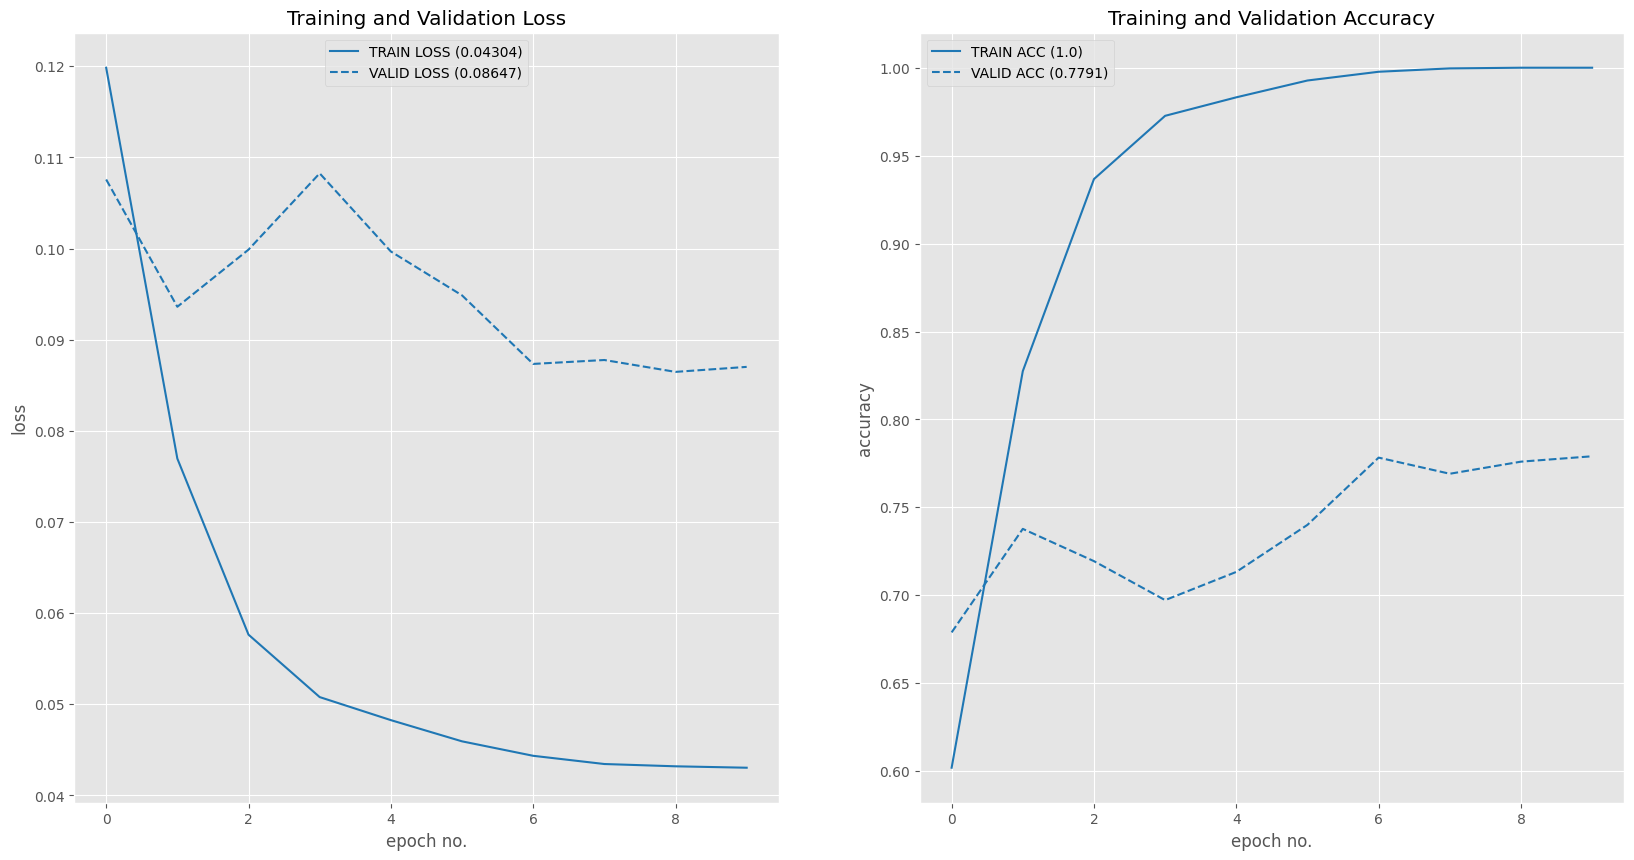

In [73]:
plot_loss_accuracy(
    train_loss=[train_loss],
    val_loss=[val_loss],
    train_acc=[train_acc],
    val_acc=[val_acc],
    colors=["blue"],
    loss_legend_loc="upper center",
    acc_legend_loc="upper left",
)

## <font style="color:green">8. TensorBoard Log Link [5 Points]</font>

**Share your TensorBoard scalars logs link here You can also share (not mandatory) your GitHub link, if you have pushed this project in GitHub.**


Note: In light of the recent shutdown of tensorboard.dev, we have updated the submission requirements for your project. Instead of sharing a tensorboard.dev link, you are now required to upload your generated TensorBoard event files directly onto the lab. As an alternative, you may also include a screenshot of your TensorBoard output within your Jupyter notebook. This adjustment ensures that your data visualization and model training efforts are thoroughly documented and accessible for evaluation.

You are also welcome (and encouraged) to utilize alternative logging services like wandB or comet. In such instances, you can easily make your project logs publicly accessible and share the link with others.

In [74]:
# Install TensorBoard if not already installed
#!pip install tensorboard

# Import necessary libraries
#import os
#import subprocess
#import time
#from torch.utils.tensorboard import SummaryWriter
#import tensorboard.notebook

#subprocess.run(["pkill", "-f", "tensorboard"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)

## Define the log directory
#log_dir = "/kaggle/working/logs"

## Create a SummaryWriter to log data for TensorBoard
#writer = SummaryWriter(log_dir=log_dir)

## Start TensorBoard
#tensorboard.notebook.start("--logdir " + log_dir)

## Display TensorBoard
#tensorboard.notebook.display(port=6006, height=800)

## <font style="color:green">9. Kaggle Profile Link [50 Points]</font>

**Share your Kaggle profile link  with us here to score , points in  the competition.**

**For full points, you need a minimum accuracy of `75%` on the test data. If accuracy is less than `70%`, you gain  no points for this section.**


**Submit `submission.csv` (prediction for images in `test.csv`), in the `Submit Predictions` tab in Kaggle, to get evaluated for  this section.**

In [75]:
https://www.kaggle.com/michaelgpurvis

SyntaxError: invalid syntax (<ipython-input-75-d445e6ff0b62>, line 1)